**Limpieza de datos**

**Objetivo general:** Construir un modelo de predicción de ventas por producto, enfocándonos en trabajar sólo en la tienda S005, para ello, usaremos series temporales a través del modelo **ARIMA**. Este análisis del modelo, se utiliza para predecir la demanda de las unidades que un producto estima vender.

**Librerías necesarias (ETL, visualización, modelado)**

In [3]:
# Importación de librerías
import pandas as pd                # Para manipular los datos en formato tabla
import numpy as np                 # Para operaciones matemáticas y manejo de arrays
import matplotlib.pyplot as plt    # Para visualizar gráficos
import seaborn as sns              # Para hacer gráficos más lindos
from statsmodels.tsa.arima.model import ARIMA  # Modelo ARIMA
from sklearn.metrics import mean_squared_error # Para evaluar el modelo

**Cargar datos y normalizar nombres de columnas**

In [4]:
# Ruta del archivo
ruta_archivo = "../data/training.csv"  #Este formato de ruta, nos evita malas prácticas.

# Cargar CSV
df = pd.read_csv(ruta_archivo)

# Normalizar columnas: quitar espacios, minúsculas, y reemplazar símbolos conflictivos
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('/', '_')
)

# Vista rápida
print("Primeras filas:")
print(df.head(5))
print("\nColumnas:")
print(df.columns.tolist())

Primeras filas:
         date store_id product_id     category region  inventory_level  \
0  2022-11-19     S005      P0020    Furniture  South              452   
1  2023-06-29     S005      P0006     Clothing  South              377   
2  2022-03-10     S005      P0010    Furniture  South              420   
3  2022-02-07     S005      P0001  Electronics  South               92   
4  2022-06-23     S005      P0015    Furniture   West              272   

   units_sold  units_ordered  demand_forecast  price  discount  \
0         432            176           442.08  84.09         0   
1         212             31           221.02  50.49        15   
2          38            185            46.02  27.34         5   
3           9             32            14.67  88.84        10   
4         250            178           268.00  98.73        20   

  weather_condition  holiday_promotion  competitor_pricing seasonality  
0             Snowy                  1               85.46      Summe

**Conversión de tipos, limpieza y filtrado por tienda S005**

In [5]:
# Convertir columna 'date' a datetime
df['date'] = pd.to_datetime(df['date']).dt.floor('D')

print(df['date'])

# Ordenar por fecha
df = df.sort_values(by='date')

# Reiniciar el índice si lo deseas (opcional pero recomendable)
df = df.reset_index(drop=True)

# Eliminar duplicados
df = df.drop_duplicates()


# Filtrar solo la tienda S005
df = df[df['store_id'] == 'S005']

# Confirmaciones
print("Tienda única:", df['store_id'].unique())
print("Tamaño del dataset:", df.shape)

0       2022-11-19
1       2023-06-29
2       2022-03-10
3       2022-02-07
4       2022-06-23
           ...    
11691   2022-09-17
11692   2023-11-02
11693   2022-09-27
11694   2022-02-13
11695   2022-12-30
Name: date, Length: 11696, dtype: datetime64[ns]
Tienda única: ['S005']
Tamaño del dataset: (11696, 15)


**Visualizar la demanda diaria**

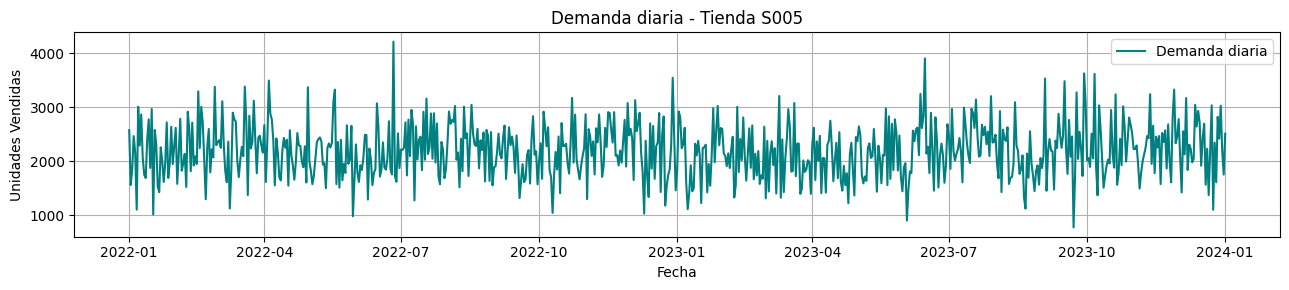

In [6]:
# Agrupar demanda diaria
daily_demand = df.groupby('date')['units_sold'].sum()

# Verificamos si la serie no está vacía
if daily_demand.empty:
    print("⚠️ La serie de demanda diaria está vacía. Revisa si hay datos reales para la tienda S005.")
else:
    # Gráfico de la serie temporal
    plt.figure(figsize=(13, 3))
    plt.plot(daily_demand, color='teal', label='Demanda diaria')
    plt.title('Demanda diaria - Tienda S005')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades Vendidas')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


En este paso, se proyectará la demanda diaria futura utilizando el modelo **ARIMA** para las series temporales, **gráfico con predicción de la demanda y métricas de error**.

**Preparación de los datos para modelo ARIMA**

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Usamos la serie ya agrupada como demanda diaria
serie = daily_demand.copy()

# Entrenamos el modelo con toda la serie
modelo = ARIMA(serie, order=(5,1,0))  # Puedes ajustar los parámetros
modelo_entrenado = modelo.fit()

c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


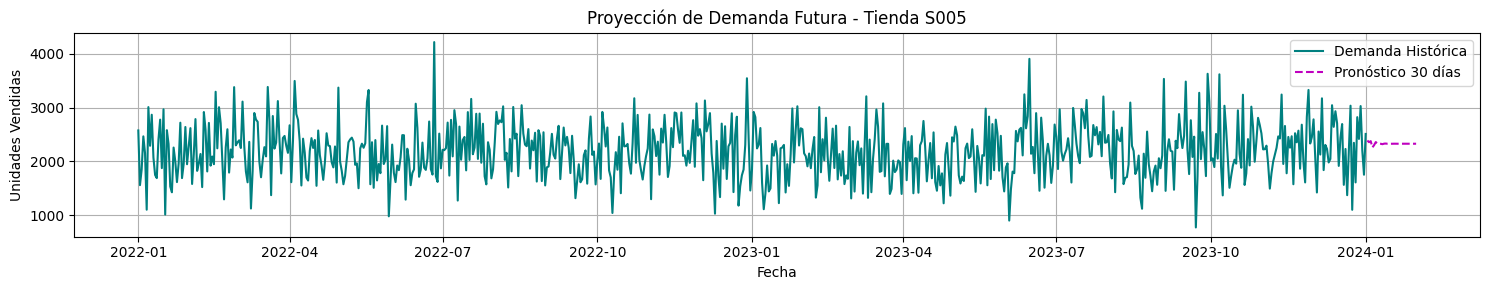

In [9]:
# Forecast para los próximos 30 días
forecast_30 = modelo_entrenado.forecast(steps=30)

# Fechas futuras
fechas_futuras = pd.date_range(start=serie.index[-1] + pd.Timedelta(days=1), periods=30)

# Graficamos
plt.figure(figsize=(15,3))
plt.plot(serie.index, serie, label='Demanda Histórica', color='teal')
plt.plot(fechas_futuras, forecast_30, label='Pronóstico 30 días', color='m', linestyle='--')
plt.title('Proyección de Demanda Futura - Tienda S005')
plt.xlabel('Fecha')
plt.ylabel('Unidades Vendidas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
print(modelo_entrenado.summary())

                               SARIMAX Results                                
Dep. Variable:             units_sold   No. Observations:                  731
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5626.748
Date:                Sun, 25 May 2025   AIC                          11265.495
Time:                        19:43:49   BIC                          11293.054
Sample:                    01-01-2022   HQIC                         11276.128
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8419      0.039    -21.504      0.000      -0.919      -0.765
ar.L2         -0.6588      0.048    -13.588      0.000      -0.754      -0.564
ar.L3         -0.4284      0.058     -7.376      0.0

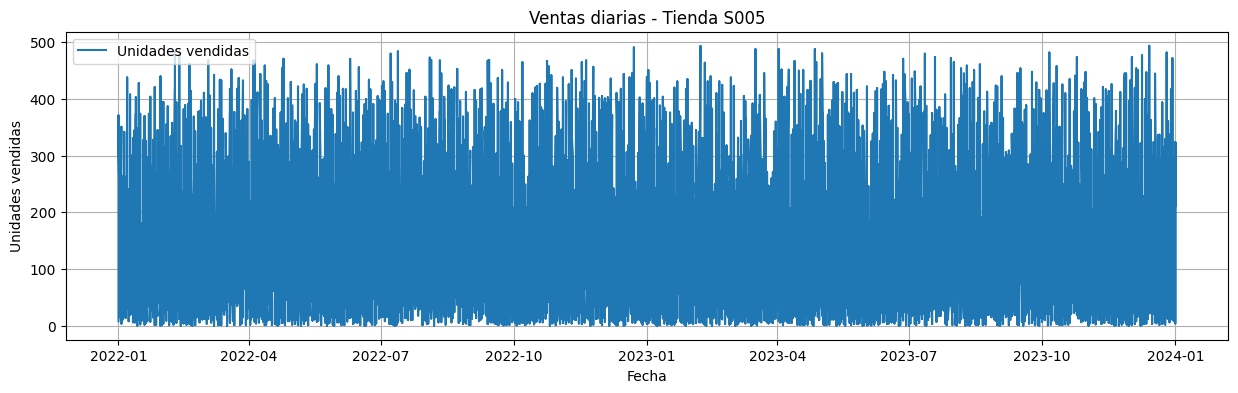

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.plot(df['date'], df['units_sold'], label='Unidades vendidas')
plt.title('Ventas diarias - Tienda S005')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.grid(True)
plt.legend()
plt.show()

In [158]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(df['units_sold']))
outliers = df[z_scores > 3]

print(f"Número de outliers detectados: {outliers.shape[0]}")
display(outliers[['date', 'units_sold']].head())

Número de outliers detectados: 38


,date,units_sold
622,2022-02-09,484
661,2022-02-12,484
985,2022-03-04,468
1480,2022-04-04,468
1508,2022-04-05,467


In [22]:
df['units_sold_clean'] = df['units_sold']
df.loc[z_scores > 3, 'units_sold_clean'] = df['units_sold'].rolling(window=5, center=True).median()


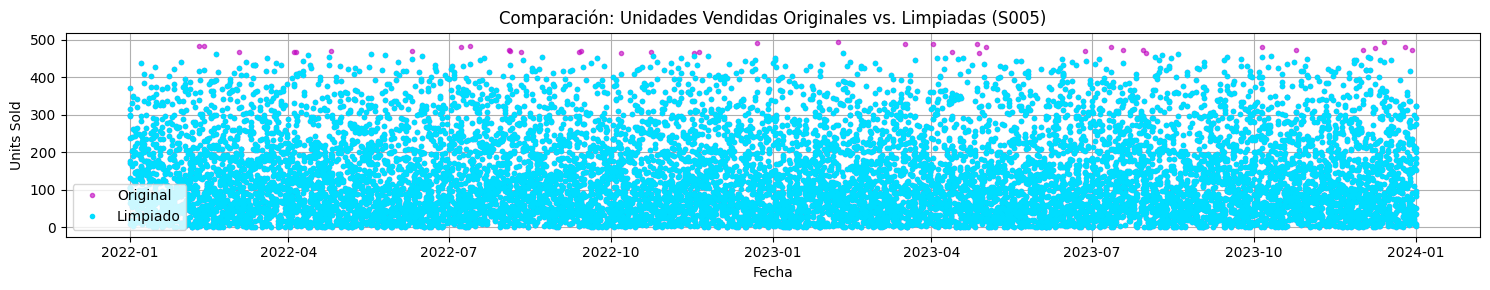

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.plot(df['date'], df['units_sold'], 'm.', alpha=0.6)
plt.plot(df['date'], df['units_sold_clean'],'.', color = (0, 0.867, 1), label='Limpiado')
plt.title('Comparación: Unidades Vendidas Originales vs. Limpiadas (S005)')
plt.xlabel('Fecha')
plt.ylabel('Units Sold')
plt.legend(['Original', 'Limpiado'], loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
print(modelo_entrenado.summary())

                               SARIMAX Results                                
Dep. Variable:             units_sold   No. Observations:                  731
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5626.748
Date:                Sun, 25 May 2025   AIC                          11265.495
Time:                        19:51:18   BIC                          11293.054
Sample:                    01-01-2022   HQIC                         11276.128
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8419      0.039    -21.504      0.000      -0.919      -0.765
ar.L2         -0.6588      0.048    -13.588      0.000      -0.754      -0.564
ar.L3         -0.4284      0.058     -7.376      0.0